In [1]:
import os
import sys
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from modules import *
from execution import *
import json

In [2]:
gpt2 = {'l': 1024, 'e': 1600, 'h': 32, 'depth': 48}
gpt3 = {'l': 2048, 'e': 12288, 'h': 96, 'depth': 96}
gpt3_1T = {'l': 2048, 'e': 25600, 'h': 160, 'depth': 180}
gpt3_lowdepth = {'l': 2048, 'e': 12288, 'h': 256, 'depth': 96 // 8}
vit_era5 = {'l': 64800, 'e': 5120, 'h': 32, 'depth': 24}
vit_era5_big = {'l': 64800, 'e': 6144, 'h': 32, 'depth': 32}
vit_era5_1px = {'l': 1036800, 'e': 6144, 'h': 32, 'depth': 32}
vit_era5_1px_big = {'l': 1036800, 'e': 12288, 'h': 96, 'depth': 96}
### model
model = vit_era5_big
model_str = 'vit_era5_big'
# model = vit_era5_1px
global_batch = 1024
l = model['l']
e = model['e']
f = 4 * e
model['f'] = f
h = model['h']
depth = model['depth']
print(model)

{'l': 64800, 'e': 6144, 'h': 32, 'depth': 32, 'f': 24576}


In [10]:
with open('config.json', 'r') as file:
    system = json.load(file)

In [4]:
def print_df(df_mlp, df_sa):
    cols = df_mlp.columns.tolist()
    layer_track_cols = ['activation_buffer', 'weights_mem', 
                        'weights_grad_mem', 'flops_fwd', 'flops_bwd', 
                        't_fwd', 't_fwd_comm', 't_bwd', 't_bwd_comm']
    display(df_mlp[cols])
    display(df_mlp[layer_track_cols].sum())
    display(df_sa[cols])
    display(df_sa[layer_track_cols].sum()) 

In [11]:
n_gpus = [2048]
global_batch_size = 4096

with open('config.json', 'r') as file:
    system = json.load(file)
system['nvlink_size'] = 4

# throughput, t, t_comm, t_mem, t_comp, mem,  wts, wts_grad, wts_optimizer_states, acts, comm_fwd, comm_bwd, flops_fwd, flops_bwd
configs = execute_1d(model, n_gpus, global_batch_size=global_batch_size, system=system, verbose=False, nlargest=10)
# print(configs[0][0][:-3])
# df_mlp=configs[0][0][-3]
# df_sa=configs[0][0][-2]

In [11]:
configs[0][0][0],configs[0][0][1],configs[0][0][3]

(21.67246715820673,
 {'t': 188.99555690174225,
  't_com': 69.80567040000001,
  't_mem': 12.774865129404501,
  't_comp': 114.65583834202339,
  'mem': 79.86962841600001,
  'wts': 0.226799616,
  'wts_grad': 0.0,
  'wts_optimizer_states': 0.0,
  'acts': 79.64282880000002,
  'comm_fwd': 0.7962624,
  'comm_bwd': 0.7962624,
  'flops_fwd': 40.9818818304,
  'flops_bwd': 94.995678854592},
 {'dp': 16, 'tp': 16, 'pp': 8, 'mbs': 1})

In [42]:
configs[0][0][3]

{'dp': 16, 'tp': 16, 'pp': 8, 'mbs': 1}

In [43]:
16*16*8

2048

In [12]:
global_batch_size = 4096
with open('config.json', 'r') as file:
    system = json.load(file)

nvs_list = [2, 4, 8, 12, 16, 20, 32]
verbose = False
plots = []

for nvs in nvs_list:
    throughput = []
    t_comm = []
    t_mem = []
    t_comp = []
    intensity = []
    mem = []
    mem_wts =[]
    mem_grad = []
    mem_optimizer = []
    acts = []
    comm_fwd = []
    comm_bwd = []
    flops = []
    # conf = []
    dps = []
    tps = []
    pps = []
    start = None
    system['nvlink_size'] = nvs
    n_gpus = 2**np.array([i for i in range(2,14)])
    configs = execute_1d(model, n_gpus, global_batch_size=global_batch_size, system=system, verbose=False, nlargest=10)
    for s,config in enumerate(configs):
        if len(config) > 0: # check feasibility
            if not start:
                start = s
            # conf.append(config)
            throughput.append([c[0] for c in config])
            t_comm.append([c[1]['t_com']/c[1]['t'] for c in config])
            intensity.append([c[1]['t_comp']/c[1]['t_mem'] for c in config])
            mem.append([c[1]['mem'] for c in config])
            mem_wts.append([c[1]['wts'] for c in config])
            mem_grad.append([c[1]['wts_grad'] for c in config])
            mem_optimizer.append([c[1]['wts_optimizer_states'] for c in config])
            acts.append([c[1]['acts'] for c in config])
            comm_fwd.append([c[1]['comm_fwd'] for c in config])
            comm_bwd.append([c[1]['comm_bwd'] for c in config])
            flops.append([c[1]['flops_fwd']+c[1]['flops_bwd'] for c in config])
            dps.append([c[3]['dp'] for c in config])
            tps.append([c[3]['tp'] for c in config])
            pps.append([c[3]['pp'] for c in config])
    # print(t)

    th_max = [tm[0] for tm in throughput]
    th_min = [tm[-1] for tm in throughput]
    tc_max = [tm[0] for tm in t_comm]
    tc_min = [tm[-1] for tm in t_comm]
    int_max = [tm[0] for tm in intensity]
    int_min = [tm[-1] for tm in intensity]
    mem_max = [tm[0] for tm in mem]
    mem_min = [tm[-1] for tm in mem]
    acts_max = [tm[0] for tm in acts]
    acts_min = [tm[-1] for tm in acts]
    
    wts_max = [tm[0] for tm in mem_wts]
    wts_min = [tm[-1] for tm in mem_wts]
    mem_grad_max = [tm[0] for tm in mem_grad]
    mem_grad_min = [tm[-1] for tm in mem_grad]
    mem_opt_max = [tm[0] for tm in mem_optimizer]
    mem_opt_min = [tm[-1] for tm in mem_optimizer]
    
    cfwd_max = [tm[0] for tm in comm_fwd]
    cfwd_min = [tm[-1] for tm in comm_fwd]
    cbwd_max = [tm[0] for tm in comm_bwd]
    cbwd_min = [tm[-1] for tm in comm_bwd]
    flops_max = [tm[0] for tm in flops]
    flops_min = [tm[-1] for tm in flops]
    dps_max = [tm[0] for tm in dps]
    dps_min = [tm[-1] for tm in dps]
    tps_max = [tm[0] for tm in tps]
    tps_min = [tm[-1] for tm in tps]
    pps_max = [tm[0] for tm in pps]
    pps_min = [tm[-1] for tm in pps]
    n_gpus = n_gpus[start:]
    
    plots.append((nvs, th_max, th_min, tc_max, tc_min, int_max, int_min, mem_max, \
                  mem_min, acts_min, acts_max, wts_max, wts_min, mem_grad_max, mem_grad_min, mem_opt_max, mem_opt_min,\
                  cfwd_max, cfwd_min, cbwd_max, cbwd_min, \
                  flops_max, flops_min, dps_max, dps_min, tps_max, tps_min, pps_max, pps_min, n_gpus))
np.save('outputs/exec_1d_{}.npy'.format(model_str), np.array(plots, dtype=object))

In [13]:
global_batch_size = 4096
with open('config.json', 'r') as file:
    system = json.load(file)

nvs_list = [2, 4, 8, 12, 16, 20, 32]
verbose = False
plots = []

for nvs in nvs_list:
    throughput = []
    t_comm = []
    intensity = []
    mem = []
    mem_wts =[]
    mem_grad = []
    mem_optimizer = []
    acts = []
    comm_fwd = []
    comm_bwd = []
    flops = []
    # conf = []
    dps = []
    tps = []
    pps = []
    start = None
    system['nvlink_size'] = nvs
    n_gpus = 2**np.array([i for i in range(2,14)])
    configs = execute_2d(model, n_gpus, global_batch_size=global_batch_size, system=system, verbose=False, nlargest=10)
    for s,config in enumerate(configs):
        if len(config) > 0: # check feasibility
            if not start:
                start = s
            # conf.append(config)
            throughput.append([c[0] for c in config])
            t_comm.append([c[1]['t_com']/c[1]['t'] for c in config])
            intensity.append([c[1]['t_comp']/c[1]['t_mem'] for c in config])
            mem.append([c[1]['mem'] for c in config])
            mem_wts.append([c[1]['wts'] for c in config])
            mem_grad.append([c[1]['wts_grad'] for c in config])
            mem_optimizer.append([c[1]['wts_optimizer_states'] for c in config])
            acts.append([c[1]['acts'] for c in config])
            comm_fwd.append([c[1]['comm_fwd'] for c in config])
            comm_bwd.append([c[1]['comm_bwd'] for c in config])
            flops.append([c[1]['flops_fwd']+c[1]['flops_bwd'] for c in config])
            dps.append([c[3]['dp'] for c in config])
            tps.append([c[3]['tp'] for c in config])
            pps.append([c[3]['pp'] for c in config])
    # print(t)

    th_max = [tm[0] for tm in throughput]
    th_min = [tm[-1] for tm in throughput]
    tc_max = [tm[0] for tm in t_comm]
    tc_min = [tm[-1] for tm in t_comm]
    int_max = [tm[0] for tm in intensity]
    int_min = [tm[-1] for tm in intensity]
    mem_max = [tm[0] for tm in mem]
    mem_min = [tm[-1] for tm in mem]
    acts_max = [tm[0] for tm in acts]
    acts_min = [tm[-1] for tm in acts]
    
    wts_max = [tm[0] for tm in mem_wts]
    wts_min = [tm[-1] for tm in mem_wts]
    mem_grad_max = [tm[0] for tm in mem_grad]
    mem_grad_min = [tm[-1] for tm in mem_grad]
    mem_opt_max = [tm[0] for tm in mem_optimizer]
    mem_opt_min = [tm[-1] for tm in mem_optimizer]
    
    cfwd_max = [tm[0] for tm in comm_fwd]
    cfwd_min = [tm[-1] for tm in comm_fwd]
    cbwd_max = [tm[0] for tm in comm_bwd]
    cbwd_min = [tm[-1] for tm in comm_bwd]
    flops_max = [tm[0] for tm in flops]
    flops_min = [tm[-1] for tm in flops]
    dps_max = [tm[0] for tm in dps]
    dps_min = [tm[-1] for tm in dps]
    tps_max = [tm[0] for tm in tps]
    tps_min = [tm[-1] for tm in tps]
    pps_max = [tm[0] for tm in pps]
    pps_min = [tm[-1] for tm in pps]
    n_gpus = n_gpus[start:]
    
    plots.append((nvs, th_max, th_min, tc_max, tc_min, int_max, int_min, mem_max, \
                  mem_min, acts_min, acts_max, wts_max, wts_min, mem_grad_max, mem_grad_min, mem_opt_max, mem_opt_min,\
                  cfwd_max, cfwd_min, cbwd_max, cbwd_min, \
                  flops_max, flops_min, dps_max, dps_min, tps_max, tps_min, pps_max, pps_min, n_gpus))
np.save('outputs/exec_2d_{}.npy'.format(model_str), np.array(plots, dtype=object))

In [ ]:
global_batch_size = 4096
with open('config.json', 'r') as file:
    system = json.load(file)

nvs_list = [2, 4, 16, 32]
verbose = False
plots = []

for nvs in nvs_list:
    t = []
    conf = []
    start = None
    system['nvlink_size'] = nvs
    n_gpus = 2**np.array([i for i in range(2,14)])
    configs, _ = execute_1d(model, n_gpus, global_batch_size=global_batch_size, system=system, verbose=False, nlargest=10)
    for s,config in enumerate(configs):
        if len(config) > 0: # check feasibility
            if not start:
                start = s
            conf.append(config)
            t.append([c[0] for c in config])
    # print(t)

    t_max = [tm[0] for tm in t]
    t_min = [tm[-1] for tm in t]
    n_gpus = n_gpus[start:]
    
    plots.append((nvs, t_max, t_min, n_gpus))
# np.save('outputs/exec_1d_{}.npy'.format(model_str), np.array(plots, dtype=object))

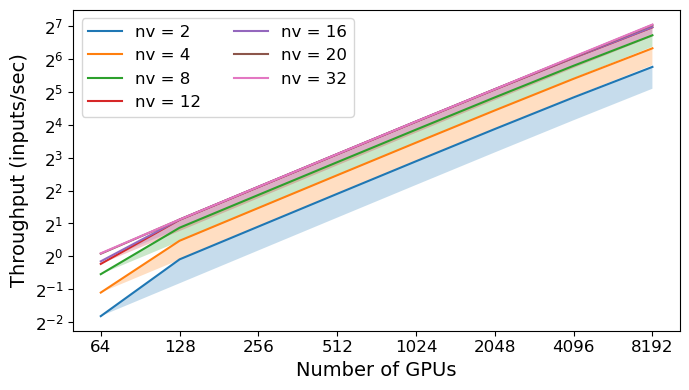

In [4]:
x = np.load('outputs/exec_1d_{}.npy'.format(model_str), allow_pickle=True)
fig, axs = plt.subplots(1,1,figsize=(7,4), tight_layout=True) 
axs.tick_params(axis='both', which='major', labelsize=12)
axs.tick_params(axis='both', which='minor', labelsize=12)
counter=0
for nvs, th_max, th_min, tc_max, tc_min, int_max, int_min, mem_max, \
                  mem_min, acts_min, acts_max, wts_max, wts_min, mem_grad_max, mem_grad_min, mem_opt_max, mem_opt_min,\
                  cfwd_max, cfwd_min, cbwd_max, cbwd_min, \
                  flops_max, flops_min, dps_max, dps_min, tps_max, tps_min, pps_max, pps_min, n_gpus in x:
    axs.plot(n_gpus, th_max, label='nv = {}'.format(nvs),color='C'+str(counter))
    # axs.plot(n_gpus, (4096/np.array(tps_max)/np.array(dps_max)), label='nv = {}'.format(nvs), color = 'C'+str(counter))
    # axs.plot(n_gpus, (4096/np.array(tps_min)/np.array(dps_min)), linestyle='--', color = 'C'+str(counter))
    axs.fill_between(n_gpus, th_min,th_max, alpha=0.25)
    # print(np.array(t_max) - np.array(t_min))
    axs.set_yscale('log', base=2)
    axs.set_xscale('log', base=2)
    axs.set_xticks(n_gpus)
    axs.set_xticklabels(n_gpus)
    axs.set_xlabel('Number of GPUs', fontsize=14)
    axs.set_ylabel('Throughput (inputs/sec)', fontsize=14)
    axs.set_yticks(2.**np.arange(-2,8))
    counter+=1
axs.legend(fontsize=12,ncols=2)
fig.tight_layout()
# plt.savefig('outputs/exec_1d_{}.png'.format(model_str), dpi=400)

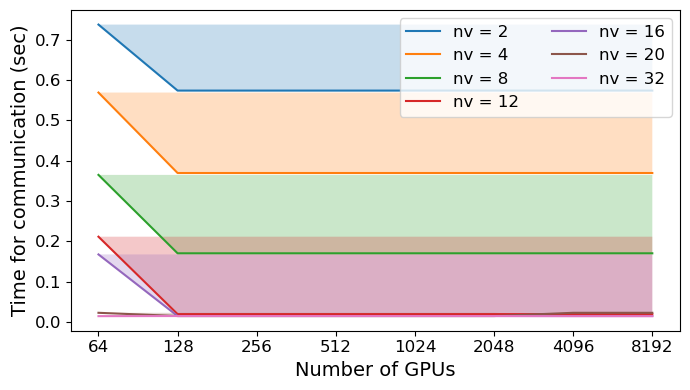

In [8]:
x = np.load('outputs/exec_1d_{}.npy'.format(model_str), allow_pickle=True)
fig, axs = plt.subplots(1,1,figsize=(7,4), tight_layout=True) 
axs.tick_params(axis='both', which='major', labelsize=12)
axs.tick_params(axis='both', which='minor', labelsize=12)
counter=0
for nvs, th_max, th_min, tc_max, tc_min, int_max, int_min, mem_max, \
                  mem_min, acts_min, acts_max, wts_max, wts_min, mem_grad_max, mem_grad_min, mem_opt_max, mem_opt_min,\
                  cfwd_max, cfwd_min, cbwd_max, cbwd_min, \
                  flops_max, flops_min, dps_max, dps_min, tps_max, tps_min, pps_max, pps_min, n_gpus in x:
    axs.plot(n_gpus, tc_max, label='nv = {}'.format(nvs),color='C'+str(counter))
    # axs.plot(n_gpus, (4096/np.array(tps_max)/np.array(dps_max)), label='nv = {}'.format(nvs), color = 'C'+str(counter))
    # axs.plot(n_gpus, (4096/np.array(tps_min)/np.array(dps_min)), linestyle='--', color = 'C'+str(counter))
    axs.fill_between(n_gpus, tc_min,tc_max, alpha=0.25)
    # print(np.array(t_max) - np.array(t_min))
    # axs.set_yscale('log', base=2)
    axs.set_xscale('log', base=2)
    axs.set_xticks(n_gpus)
    axs.set_xticklabels(n_gpus)
    axs.set_xlabel('Number of GPUs', fontsize=14)
    axs.set_ylabel('Time for communication (sec)', fontsize=14)
    # axs.set_yticks(2.**np.arange(-2,8))
    counter+=1
axs.legend(fontsize=12,ncols=2)
fig.tight_layout()
# plt.savefig('outputs/exec_1d_{}.png'.format(model_str), dpi=400)

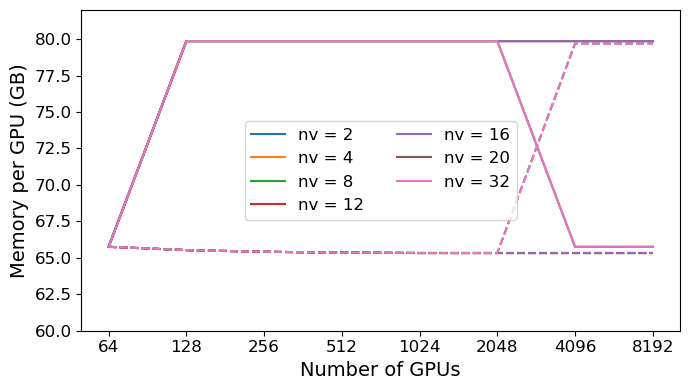

In [17]:
x = np.load('outputs/exec_1d_{}.npy'.format(model_str), allow_pickle=True)
fig, axs = plt.subplots(1,1,figsize=(7,4), tight_layout=True) 
axs.tick_params(axis='both', which='major', labelsize=12)
axs.tick_params(axis='both', which='minor', labelsize=12)
counter=0
for nvs, th_max, th_min, tc_max, tc_min, int_max, int_min, mem_max, \
                  mem_min, acts_min, acts_max, wts_max, wts_min, mem_grad_max, mem_grad_min, mem_opt_max, mem_opt_min,\
                  cfwd_max, cfwd_min, cbwd_max, cbwd_min, \
                  flops_max, flops_min, dps_max, dps_min, tps_max, tps_min, pps_max, pps_min, n_gpus in x:
    axs.plot(n_gpus, mem_max, label='nv = {}'.format(nvs),color='C'+str(counter))
    # axs.plot(n_gpus, (4096/np.array(tps_max)/np.array(dps_max)), label='nv = {}'.format(nvs), color = 'C'+str(counter))
    axs.plot(n_gpus, mem_min, linestyle='--', color = 'C'+str(counter))
    # axs.fill_between(n_gpus, tc_min,tc_max, alpha=0.25)
    # print(np.array(t_max) - np.array(t_min))
    # axs.set_yscale('log', base=2)
    axs.set_xscale('log', base=2)
    axs.set_xticks(n_gpus)
    axs.set_xticklabels(n_gpus)
    axs.set_xlabel('Number of GPUs', fontsize=14)
    axs.set_ylabel('Memory per GPU (GB)', fontsize=14)
    axs.set_ylim(60,82)
    # axs.set_yticks(2.**np.arange(-2,8))
    counter+=1
axs.legend(fontsize=12,ncols=2)
fig.tight_layout()
# plt.savefig('outputs/exec_1d_{}.png'.format(model_str), dpi=400)

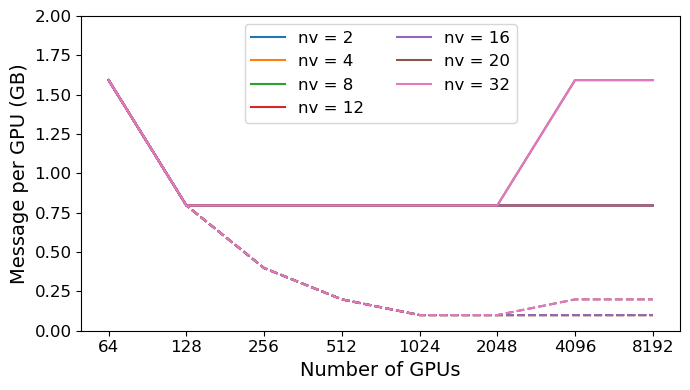

In [18]:
x = np.load('outputs/exec_1d_{}.npy'.format(model_str), allow_pickle=True)
fig, axs = plt.subplots(1,1,figsize=(7,4), tight_layout=True) 
axs.tick_params(axis='both', which='major', labelsize=12)
axs.tick_params(axis='both', which='minor', labelsize=12)
counter=0
for nvs, th_max, th_min, tc_max, tc_min, int_max, int_min, mem_max, \
                  mem_min, acts_min, acts_max, wts_max, wts_min, mem_grad_max, mem_grad_min, mem_opt_max, mem_opt_min,\
                  cfwd_max, cfwd_min, cbwd_max, cbwd_min, \
                  flops_max, flops_min, dps_max, dps_min, tps_max, tps_min, pps_max, pps_min, n_gpus in x:
    axs.plot(n_gpus, cfwd_max, label='nv = {}'.format(nvs),color='C'+str(counter))
    # axs.plot(n_gpus, (4096/np.array(tps_max)/np.array(dps_max)), label='nv = {}'.format(nvs), color = 'C'+str(counter))
    axs.plot(n_gpus, cfwd_min, linestyle='--', color = 'C'+str(counter))
    # axs.fill_between(n_gpus, tc_min,tc_max, alpha=0.25)
    # print(np.array(t_max) - np.array(t_min))
    # axs.set_yscale('log', base=2)
    axs.set_xscale('log', base=2)
    axs.set_xticks(n_gpus)
    axs.set_xticklabels(n_gpus)
    axs.set_xlabel('Number of GPUs', fontsize=14)
    axs.set_ylabel('Message per GPU (GB)', fontsize=14)
    axs.set_ylim(0,2)
    # axs.set_yticks(2.**np.arange(-2,8))
    counter+=1
axs.legend(fontsize=12,ncols=2)
fig.tight_layout()
# plt.savefig('outputs/exec_1d_{}.png'.format(model_str), dpi=400)

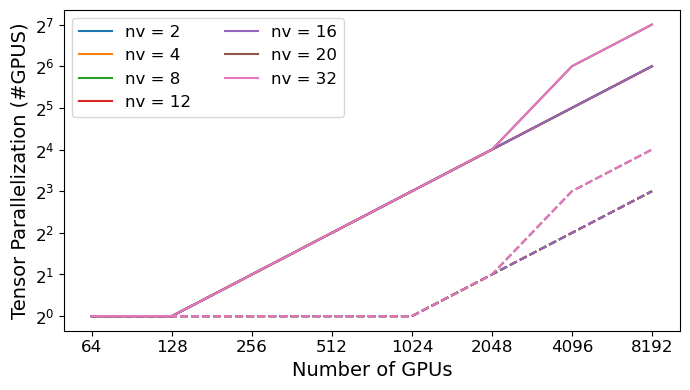

In [42]:
x = np.load('outputs/exec_1d_{}.npy'.format(model_str), allow_pickle=True)
fig, axs = plt.subplots(1,1,figsize=(7,4), tight_layout=True) 
axs.tick_params(axis='both', which='major', labelsize=12)
axs.tick_params(axis='both', which='minor', labelsize=12)
counter=0
for nvs, th_max, th_min, tc_max, tc_min, int_max, int_min, mem_max, \
                  mem_min, acts_min, acts_max, wts_max, wts_min, mem_grad_max, mem_grad_min, mem_opt_max, mem_opt_min,\
                  cfwd_max, cfwd_min, cbwd_max, cbwd_min, \
                  flops_max, flops_min, dps_max, dps_min, tps_max, tps_min, pps_max, pps_min, n_gpus in x:
    axs.plot(n_gpus, dps_max, label='nv = {}'.format(nvs),color='C'+str(counter))
    # axs.plot(n_gpus, (4096/np.array(tps_max)/np.array(dps_max)), label='nv = {}'.format(nvs), color = 'C'+str(counter))
    axs.plot(n_gpus, dps_min, linestyle='--', color = 'C'+str(counter))
    # axs.fill_between(n_gpus, tc_min,tc_max, alpha=0.25)
    # print(np.array(t_max) - np.array(t_min))
    axs.set_yscale('log', base=2)
    axs.set_xscale('log', base=2)
    axs.set_xticks(n_gpus)
    axs.set_xticklabels(n_gpus)
    axs.set_xlabel('Number of GPUs', fontsize=14)
    axs.set_ylabel('Tensor Parallelization (#GPUS)', fontsize=14)
    # axs.set_ylim(10,35)
    # axs.set_yticks(2.**np.arange(-2,8))
    counter+=1
axs.legend(fontsize=12,ncols=2)
fig.tight_layout()
# plt.savefig('outputs/exec_1d_{}.png'.format(model_str), dpi=400)

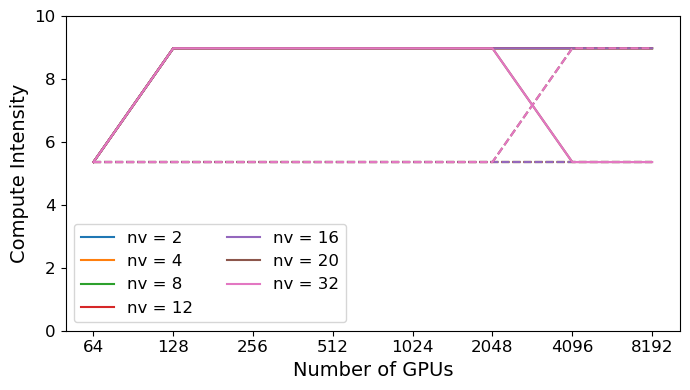

In [25]:
x = np.load('outputs/exec_1d_{}.npy'.format(model_str), allow_pickle=True)
fig, axs = plt.subplots(1,1,figsize=(7,4), tight_layout=True) 
axs.tick_params(axis='both', which='major', labelsize=12)
axs.tick_params(axis='both', which='minor', labelsize=12)
counter=0
for nvs, th_max, th_min, tc_max, tc_min, int_max, int_min, mem_max, \
                  mem_min, acts_min, acts_max, wts_max, wts_min, mem_grad_max, mem_grad_min, mem_opt_max, mem_opt_min,\
                  cfwd_max, cfwd_min, cbwd_max, cbwd_min, \
                  flops_max, flops_min, dps_max, dps_min, tps_max, tps_min, pps_max, pps_min, n_gpus in x:
    axs.plot(n_gpus, int_max, label='nv = {}'.format(nvs),color='C'+str(counter))
    # axs.plot(n_gpus, (4096/np.array(tps_max)/np.array(dps_max)), label='nv = {}'.format(nvs), color = 'C'+str(counter))
    axs.plot(n_gpus, int_min, linestyle='--', color = 'C'+str(counter))
    # axs.fill_between(n_gpus, tc_min,tc_max, alpha=0.25)
    # print(np.array(t_max) - np.array(t_min))
    # axs.set_yscale('log', base=2)
    axs.set_xscale('log', base=2)
    axs.set_xticks(n_gpus)
    axs.set_xticklabels(n_gpus)
    axs.set_xlabel('Number of GPUs', fontsize=14)
    axs.set_ylabel('Compute Intensity', fontsize=14)
    axs.set_ylim(0,10)
    # axs.set_yticks(2.**np.arange(-2,8))
    counter+=1
axs.legend(fontsize=12,ncols=2)
fig.tight_layout()
# plt.savefig('outputs/exec_1d_{}.png'.format(model_str), dpi=400)

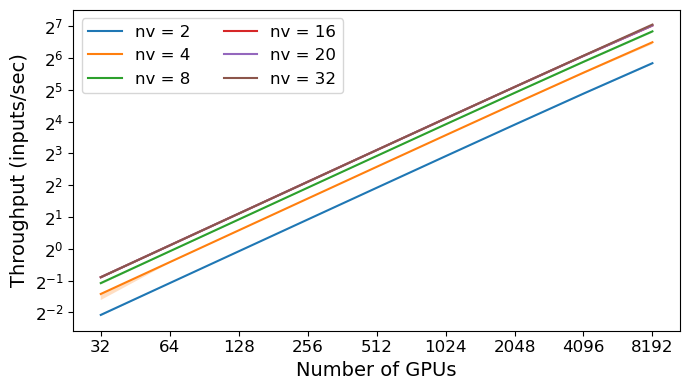

In [29]:
x = np.load('outputs/exec_2d_{}.npy'.format(model_str), allow_pickle=True)
fig, axs = plt.subplots(1,1,figsize=(7,4), tight_layout=True) 
axs.tick_params(axis='both', which='major', labelsize=12)
axs.tick_params(axis='both', which='minor', labelsize=12)
counter=0
for nvs, th_max, th_min, tc_max, tc_min, int_max, int_min, mem_max, \
                  mem_min, acts_min, acts_max, wts_max, wts_min, mem_grad_max, mem_grad_min, mem_opt_max, mem_opt_min,\
                  cfwd_max, cfwd_min, cbwd_max, cbwd_min, \
                  flops_max, flops_min, dps_max, dps_min, tps_max, tps_min, pps_max, pps_min, n_gpus in x:
    try:
        axs.plot(n_gpus, th_max, label='nv = {}'.format(nvs),color='C'+str(counter))
    # axs.plot(n_gpus, (4096/np.array(tps_max)/np.array(dps_max)), label='nv = {}'.format(nvs), color = 'C'+str(counter))
    # axs.plot(n_gpus, (4096/np.array(tps_min)/np.array(dps_min)), linestyle='--', color = 'C'+str(counter))
        axs.fill_between(n_gpus, th_min,th_max, alpha=0.25)
    # print(np.array(t_max) - np.array(t_min))
    except:
        continue
    axs.set_yscale('log', base=2)
    axs.set_xscale('log', base=2)
    axs.set_xticks(n_gpus)
    axs.set_xticklabels(n_gpus)
    axs.set_xlabel('Number of GPUs', fontsize=14)
    axs.set_ylabel('Throughput (inputs/sec)', fontsize=14)
    axs.set_yticks(2.**np.arange(-2,8))
    counter+=1
axs.legend(fontsize=12,ncols=2)
fig.tight_layout()
# plt.savefig('outputs/exec_1d_{}.png'.format(model_str), dpi=400)

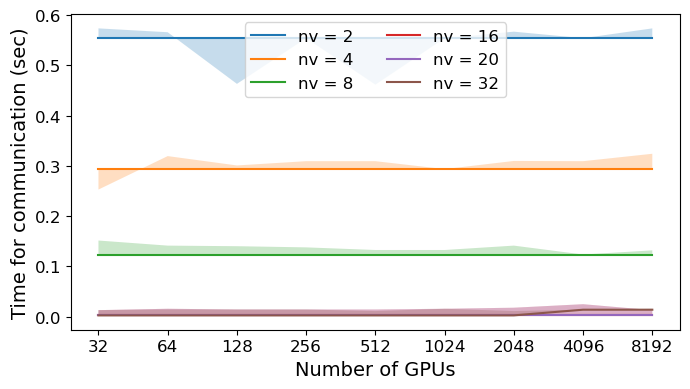

In [31]:
x = np.load('outputs/exec_2d_{}.npy'.format(model_str), allow_pickle=True)
fig, axs = plt.subplots(1,1,figsize=(7,4), tight_layout=True) 
axs.tick_params(axis='both', which='major', labelsize=12)
axs.tick_params(axis='both', which='minor', labelsize=12)
counter=0
for nvs, th_max, th_min, tc_max, tc_min, int_max, int_min, mem_max, \
                  mem_min, acts_min, acts_max, wts_max, wts_min, mem_grad_max, mem_grad_min, mem_opt_max, mem_opt_min,\
                  cfwd_max, cfwd_min, cbwd_max, cbwd_min, \
                  flops_max, flops_min, dps_max, dps_min, tps_max, tps_min, pps_max, pps_min, n_gpus in x:
    try:
        axs.plot(n_gpus, tc_max, label='nv = {}'.format(nvs),color='C'+str(counter))
    # axs.plot(n_gpus, (4096/np.array(tps_max)/np.array(dps_max)), label='nv = {}'.format(nvs), color = 'C'+str(counter))
    # axs.plot(n_gpus, (4096/np.array(tps_min)/np.array(dps_min)), linestyle='--', color = 'C'+str(counter))
        axs.fill_between(n_gpus, tc_min,tc_max, alpha=0.25)
    except:
        continue
    # print(np.array(t_max) - np.array(t_min))
    # axs.set_yscale('log', base=2)
    axs.set_xscale('log', base=2)
    axs.set_xticks(n_gpus)
    axs.set_xticklabels(n_gpus)
    axs.set_xlabel('Number of GPUs', fontsize=14)
    axs.set_ylabel('Time for communication (sec)', fontsize=14)
    # axs.set_yticks(2.**np.arange(-2,8))
    counter+=1
axs.legend(fontsize=12,ncols=2)
fig.tight_layout()
# plt.savefig('outputs/exec_1d_{}.png'.format(model_str), dpi=400)

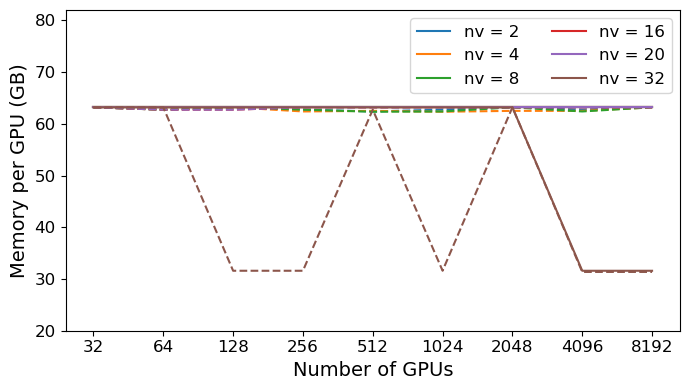

In [36]:
x = np.load('outputs/exec_2d_{}.npy'.format(model_str), allow_pickle=True)
fig, axs = plt.subplots(1,1,figsize=(7,4), tight_layout=True) 
axs.tick_params(axis='both', which='major', labelsize=12)
axs.tick_params(axis='both', which='minor', labelsize=12)
counter=0
for nvs, th_max, th_min, tc_max, tc_min, int_max, int_min, mem_max, \
                  mem_min, acts_min, acts_max, wts_max, wts_min, mem_grad_max, mem_grad_min, mem_opt_max, mem_opt_min,\
                  cfwd_max, cfwd_min, cbwd_max, cbwd_min, \
                  flops_max, flops_min, dps_max, dps_min, tps_max, tps_min, pps_max, pps_min, n_gpus in x:
    try:
        axs.plot(n_gpus, mem_max, label='nv = {}'.format(nvs),color='C'+str(counter))
    # axs.plot(n_gpus, (4096/np.array(tps_max)/np.array(dps_max)), label='nv = {}'.format(nvs), color = 'C'+str(counter))
        axs.plot(n_gpus, mem_min, linestyle='--', color = 'C'+str(counter))
    except:
        continue
    # axs.fill_between(n_gpus, tc_min,tc_max, alpha=0.25)
    # print(np.array(t_max) - np.array(t_min))
    # axs.set_yscale('log', base=2)
    axs.set_xscale('log', base=2)
    axs.set_xticks(n_gpus)
    axs.set_xticklabels(n_gpus)
    axs.set_xlabel('Number of GPUs', fontsize=14)
    axs.set_ylabel('Memory per GPU (GB)', fontsize=14)
    axs.set_ylim(20,82)
    # axs.set_yticks(2.**np.arange(-2,8))
    counter+=1
axs.legend(fontsize=12,ncols=2)
fig.tight_layout()
# plt.savefig('outputs/exec_1d_{}.png'.format(model_str), dpi=400)

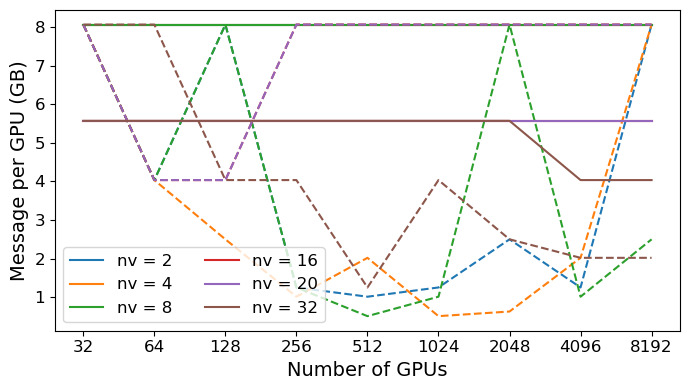

In [38]:
x = np.load('outputs/exec_2d_{}.npy'.format(model_str), allow_pickle=True)
fig, axs = plt.subplots(1,1,figsize=(7,4), tight_layout=True) 
axs.tick_params(axis='both', which='major', labelsize=12)
axs.tick_params(axis='both', which='minor', labelsize=12)
counter=0
for nvs, th_max, th_min, tc_max, tc_min, int_max, int_min, mem_max, \
                  mem_min, acts_min, acts_max, wts_max, wts_min, mem_grad_max, mem_grad_min, mem_opt_max, mem_opt_min,\
                  cfwd_max, cfwd_min, cbwd_max, cbwd_min, \
                  flops_max, flops_min, dps_max, dps_min, tps_max, tps_min, pps_max, pps_min, n_gpus in x:
    try:
        axs.plot(n_gpus, cfwd_max, label='nv = {}'.format(nvs),color='C'+str(counter))
    # axs.plot(n_gpus, (4096/np.array(tps_max)/np.array(dps_max)), label='nv = {}'.format(nvs), color = 'C'+str(counter))
        axs.plot(n_gpus, cfwd_min, linestyle='--', color = 'C'+str(counter))
    except:
        continue
    # axs.fill_between(n_gpus, tc_min,tc_max, alpha=0.25)
    # print(np.array(t_max) - np.array(t_min))
    # axs.set_yscale('log', base=2)
    axs.set_xscale('log', base=2)
    axs.set_xticks(n_gpus)
    axs.set_xticklabels(n_gpus)
    axs.set_xlabel('Number of GPUs', fontsize=14)
    axs.set_ylabel('Message per GPU (GB)', fontsize=14)
    # axs.set_ylim(0,2)
    # axs.set_yticks(2.**np.arange(-2,8))
    counter+=1
axs.legend(fontsize=12,ncols=2)
fig.tight_layout()
# plt.savefig('outputs/exec_1d_{}.png'.format(model_str), dpi=400)

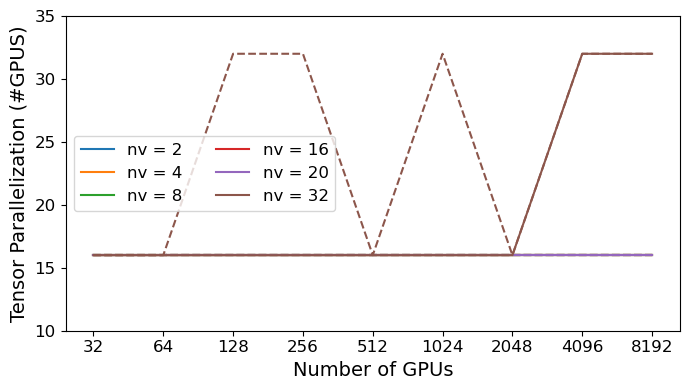

In [39]:
x = np.load('outputs/exec_2d_{}.npy'.format(model_str), allow_pickle=True)
fig, axs = plt.subplots(1,1,figsize=(7,4), tight_layout=True) 
axs.tick_params(axis='both', which='major', labelsize=12)
axs.tick_params(axis='both', which='minor', labelsize=12)
counter=0
for nvs, th_max, th_min, tc_max, tc_min, int_max, int_min, mem_max, \
                  mem_min, acts_min, acts_max, wts_max, wts_min, mem_grad_max, mem_grad_min, mem_opt_max, mem_opt_min,\
                  cfwd_max, cfwd_min, cbwd_max, cbwd_min, \
                  flops_max, flops_min, dps_max, dps_min, tps_max, tps_min, pps_max, pps_min, n_gpus in x:
    try:
        axs.plot(n_gpus, tps_max, label='nv = {}'.format(nvs),color='C'+str(counter))
    # axs.plot(n_gpus, (4096/np.array(tps_max)/np.array(dps_max)), label='nv = {}'.format(nvs), color = 'C'+str(counter))
        axs.plot(n_gpus, tps_min, linestyle='--', color = 'C'+str(counter))
    except:
        continue
    # axs.fill_between(n_gpus, tc_min,tc_max, alpha=0.25)
    # print(np.array(t_max) - np.array(t_min))
    # axs.set_yscale('log', base=2)
    axs.set_xscale('log', base=2)
    axs.set_xticks(n_gpus)
    axs.set_xticklabels(n_gpus)
    axs.set_xlabel('Number of GPUs', fontsize=14)
    axs.set_ylabel('Tensor Parallelization (#GPUS)', fontsize=14)
    axs.set_ylim(10,35)
    # axs.set_yticks(2.**np.arange(-2,8))
    counter+=1
axs.legend(fontsize=12,ncols=2)
fig.tight_layout()
# plt.savefig('outputs/exec_1d_{}.png'.format(model_str), dpi=400)

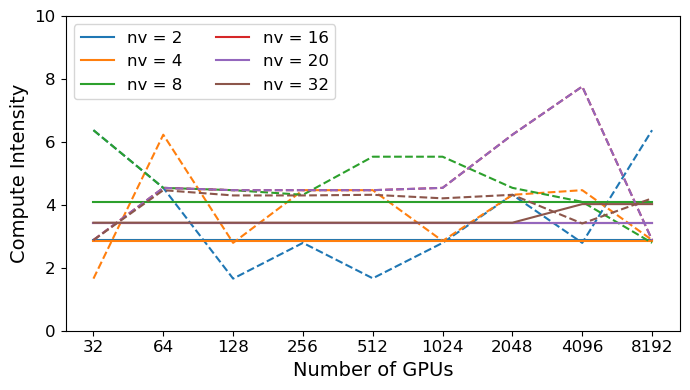

In [40]:
x = np.load('outputs/exec_2d_{}.npy'.format(model_str), allow_pickle=True)
fig, axs = plt.subplots(1,1,figsize=(7,4), tight_layout=True) 
axs.tick_params(axis='both', which='major', labelsize=12)
axs.tick_params(axis='both', which='minor', labelsize=12)
counter=0
for nvs, th_max, th_min, tc_max, tc_min, int_max, int_min, mem_max, \
                  mem_min, acts_min, acts_max, wts_max, wts_min, mem_grad_max, mem_grad_min, mem_opt_max, mem_opt_min,\
                  cfwd_max, cfwd_min, cbwd_max, cbwd_min, \
                  flops_max, flops_min, dps_max, dps_min, tps_max, tps_min, pps_max, pps_min, n_gpus in x:
    try:
        axs.plot(n_gpus, int_max, label='nv = {}'.format(nvs),color='C'+str(counter))
    # axs.plot(n_gpus, (4096/np.array(tps_max)/np.array(dps_max)), label='nv = {}'.format(nvs), color = 'C'+str(counter))
        axs.plot(n_gpus, int_min, linestyle='--', color = 'C'+str(counter))
    except:
        continue
    # axs.fill_between(n_gpus, tc_min,tc_max, alpha=0.25)
    # print(np.array(t_max) - np.array(t_min))
    # axs.set_yscale('log', base=2)
    axs.set_xscale('log', base=2)
    axs.set_xticks(n_gpus)
    axs.set_xticklabels(n_gpus)
    axs.set_xlabel('Number of GPUs', fontsize=14)
    axs.set_ylabel('Compute Intensity', fontsize=14)
    axs.set_ylim(0,10)
    # axs.set_yticks(2.**np.arange(-2,8))
    counter+=1
axs.legend(fontsize=12,ncols=2)
fig.tight_layout()
# plt.savefig('outputs/exec_1d_{}.png'.format(model_str), dpi=400)